In [1]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset
import pandas as pd
import torchaudio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchsummary import summary
import numpy as np

%load_ext autoreload
%autoreload 2

In [2]:
from scripts.dataset import EmotionDataset
from scripts.cnnnet import CNNNetwork
from scripts.inference import predict
from scripts.train import train
from scripts.train import create_data_loader

In [3]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [4]:
RECORDING_DF_PATH = os.path.join('data', 'recording_paths.csv')
DATA_DIR = os.path.join('data', 'Crema')
FINAL_SR = 16000
NUM_SAMPLES_LIMIT = 60000
BATCH_SIZE = 128
EPOCHS = 25
LEARNING_RATE = 0.0001

In [5]:
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=FINAL_SR,
        n_fft=1024,
        hop_length=512,
        n_mels=64
    )

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

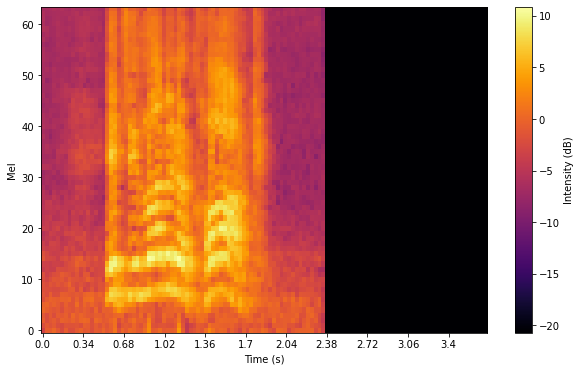

In [6]:
emd = EmotionDataset(RECORDING_DF_PATH, DATA_DIR, FINAL_SR, NUM_SAMPLES_LIMIT, mel_spectrogram, device)
emd.plot_spectrogram(200, log=True)

In [7]:
train_dataloader = create_data_loader(emd, BATCH_SIZE)

cnn = CNNNetwork(num_layers=4).to(device)
print(summary(cnn, (1, 64, 118)))
print()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(),
                             lr=LEARNING_RATE)

train(cnn.cuda(), train_dataloader, loss_fn, optimizer, device, EPOCHS)

torch.save(cnn.state_dict(), "models/cnn.pth")
print("Trained cnn saved at models/cnn.pth")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 66, 120]             160
              ReLU-2          [-1, 16, 66, 120]               0
         MaxPool2d-3           [-1, 16, 33, 60]               0
            Conv2d-4           [-1, 32, 35, 62]           4,640
              ReLU-5           [-1, 32, 35, 62]               0
         MaxPool2d-6           [-1, 32, 17, 31]               0
            Conv2d-7           [-1, 64, 19, 33]          18,496
              ReLU-8           [-1, 64, 19, 33]               0
         MaxPool2d-9            [-1, 64, 9, 16]               0
           Conv2d-10          [-1, 128, 11, 18]          73,856
             ReLU-11          [-1, 128, 11, 18]               0
        MaxPool2d-12            [-1, 128, 5, 9]               0
          Flatten-13                 [-1, 5760]               0
           Linear-14                   

In [8]:
class_mapping = ['ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD']

state_dict = torch.load("models/cnn.pth")
cnn.load_state_dict(state_dict)

idx = 1

inp, target = emd[idx][0], emd[idx][1]
inp.unsqueeze_(0)

predicted, expected = predict(cnn, inp, target, class_mapping)
print(f"Predicted: '{predicted}', expected: '{expected}'")

Predicted: 'NEU', expected: 'SAD'


In [9]:
train_df = pd.read_csv('data/recording_paths.csv')
expected = train_df.category

predictions = []
for i in range(len(emd)):
    inp, target = emd[i][0], emd[i][1]
    inp.unsqueeze_(0)
    predictions.append(predict(cnn, inp, target, class_mapping)[0])
    
    if i % 1000 == 0:
        print(f'{i} / {len(emd)} Done')

0 / 7442 Done
1000 / 7442 Done
2000 / 7442 Done
3000 / 7442 Done
4000 / 7442 Done
5000 / 7442 Done
6000 / 7442 Done
7000 / 7442 Done


In [10]:
confusion_matrix(expected, np.array(predictions))

array([[900,  86,  23, 211,  45,   6],
       [ 92, 520, 104, 156, 176, 223],
       [111,  98, 450, 273,  98, 241],
       [165, 100, 125, 663, 177,  41],
       [ 10, 125,  76,  70, 705, 101],
       [  9, 110, 144,  24, 180, 804]])

In [11]:
from sklearn.metrics import classification_report

print(classification_report(expected, np.array(predictions)))

              precision    recall  f1-score   support

         ANG       0.70      0.71      0.70      1271
         DIS       0.50      0.41      0.45      1271
         FEA       0.49      0.35      0.41      1271
         HAP       0.47      0.52      0.50      1271
         NEU       0.51      0.65      0.57      1087
         SAD       0.57      0.63      0.60      1271

    accuracy                           0.54      7442
   macro avg       0.54      0.55      0.54      7442
weighted avg       0.54      0.54      0.54      7442

